# Customized Product Proposal - Recommender System

--------------------------------------------------------

@author: jl-datascientist (Jérémy Lecourt)

Objectif:
Système avancé de recommandation de produits afin d'effectuer des propositions personnalisées selon les profils des clients.

Cadre du projet:
Application pour élaborer une proposition personnalisée de Films adaptée selon les profils des individus, en utilisant un jeux de données obtenus depuis le site Imdb.com, plus grand recueil de films/notations utilisateurs sur la toile.

--------------------------------------------------------

## Etape 1 : Chargement du jeux de données (source Imdb.com)

In [1]:
import numpy as np
import pandas as pd

from sklearn import model_selection, preprocessing

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

# 1-Collect data from Imdb.com
# 1.1-Collect movies data (table 1 : data_m)

#       Collect from first dataset
df_m = pd.read_csv("movies.csv")
df_l = pd.read_csv("links.csv")
data_m1 = pd.merge(df_m, df_l, how = 'inner')
print(data_m1.shape)

#       Collect from second dataset
df_b = pd.read_csv('basics.tsv', sep="\t")
df_a = pd.read_csv('ratings.tsv', sep="\t")
data_m2 = pd.merge(df_a, df_b, how = 'inner')
print(data_m2.shape)

#       Merging the 2 datasets via imdbId
data_m1['imdbId'] = data_m1['imdbId'].apply(str).apply(lambda x : 'tt0' + x )

data_m = data_m1.merge(data_m2, left_on = "imdbId", right_on = "tconst")
print(data_m.shape)

#print(df_b.columns, df_l.columns, df_l.shape, df_b.shape, fusion.shape)
data_m[(data_m['tconst']=='tt0114709')].head()


(27278, 5)
(1078637, 11)
(10983, 16)


,movieId,title,genres_x,imdbId,tmdbId,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,tt0114709,862.0,tt0114709,8.3,867989,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy"


In [2]:
#      Data filtering, cleaning & reformating

data_m = data_m[(data_m['titleType']=='movie') & (data_m['isAdult']!=1)]

to_drop_col = ['title', 'genres_x', 'tmdbId','tconst', 'titleType','primaryTitle','isAdult','endYear']
data_m = data_m.drop(to_drop_col,axis=1)

#pd.set_option('display.max_rows', 500)
#data_m['runtimeMinutes'].value_counts()
#data_m[data_m['runtimeMinutes'].str.contains('N')==True].head(20)
to_drop_row = data_m[data_m['runtimeMinutes'].str.contains('N')==True].index
data_m = data_m.drop(to_drop_row)

data_m['runtimeMinutes'] = data_m['runtimeMinutes'].astype(int)
data_m['startYear'] = data_m['startYear'].astype(int)

print(data_m.shape)
data_m.info()

(9607, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9607 entries, 0 to 10982
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieId         9607 non-null   int64  
 1   imdbId          9607 non-null   object 
 2   averageRating   9607 non-null   float64
 3   numVotes        9607 non-null   int64  
 4   originalTitle   9607 non-null   object 
 5   startYear       9607 non-null   int32  
 6   runtimeMinutes  9607 non-null   int32  
 7   genres_y        9607 non-null   object 
dtypes: float64(1), int32(2), int64(2), object(3)
memory usage: 600.4+ KB


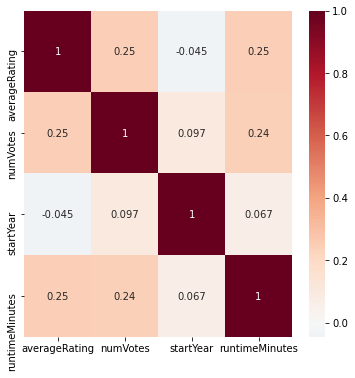

In [3]:
#      Pre-visualisation / dependencies table 1
to_drop_colviz1 = ['movieId']
viz_init1 = data_m.drop(to_drop_colviz1,axis=1)

plt.figure(figsize=(6,6))
sns.heatmap(viz_init1.corr(),  annot=True, cmap="RdBu_r", center =0);

In [4]:
# 1.2-Collect ratings data (table 2 : data_r)

#      Get main data from previous table(data_m)
data_r = data_m[['movieId','originalTitle','averageRating','numVotes']]

#      Collect ratings data and merge to get table 2(data_r)
df_r = pd.read_csv("ratings.csv")
print(data_r.shape,df_r.shape)
data_r = data_r.merge(df_r)
print(data_r.shape)

#      Data filtering, cleaning & reformating
# Filtre Review récentes??? Client avec Nbmini Rating???
data_r['date_rating'] = pd.to_datetime(data_r['timestamp'], unit='s')

print('Nb Ratings null :',data_r[(data_r['rating'].isnull()==True)].count()[0])

data_r.head()
#print(df_m.iloc[26277], df_l.iloc[26277], df_m.shape, df_l.shape,df_r.shape)


(9607, 4) (20000263, 4)
(13154979, 7)
Nb Ratings null : 0


,movieId,originalTitle,averageRating,numVotes,userId,rating,timestamp,date_rating
0,1,Toy Story,8.3,867989,3,4.0,944919407,1999-12-11 13:36:47
1,1,Toy Story,8.3,867989,6,5.0,858275452,1997-03-13 17:50:52
2,1,Toy Story,8.3,867989,8,4.0,833981871,1996-06-05 13:37:51
3,1,Toy Story,8.3,867989,10,4.0,943497887,1999-11-25 02:44:47
4,1,Toy Story,8.3,867989,11,4.5,1230858821,2009-01-02 01:13:41


In [5]:
#Test du merge OK
print(data_r[(data_r['movieId']==1000)].shape)
print(df_r[(df_r['movieId']==1000)].shape)
print(data_r[(data_r['movieId']==2000)].shape)
print(df_r[(df_r['movieId']==2000)].shape)

print('Nb Ratings null :',data_r[(data_r['rating'].isnull()==True)].count()[0])
#data_r[(data_r['movieId']==1000)].count()
#data_r[(data_r['movieId']==1000)].head(250)

(203, 8)
(203, 4)
(0, 8)
(17620, 4)
Nb Ratings null : 0


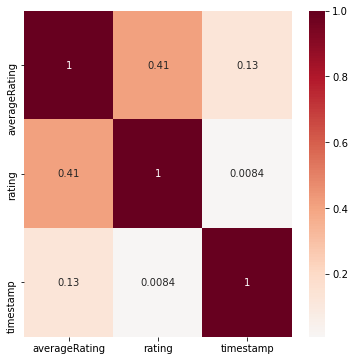

In [6]:
#      Pre-visualisation / dependencies table 2
to_drop_colviz2 = ['movieId','userId','numVotes']
#to_drop_colviz2 = ['movieId','userId']
viz_init2 = data_r.drop(to_drop_colviz2,axis=1)

plt.figure(figsize=(6,6))
sns.heatmap(viz_init2.corr(),  annot=True, cmap="RdBu_r", center =0);

In [7]:
# Other data (principals associated to each movie)

#df_i1 = pd.read_csv('akas.tsv', sep="\t", nrows=2004)
#df_i2 = pd.read_csv('principals.tsv', sep="\t", nrows=20)

In [ ]:
# SAVE TABLE 1 & 2 FOR NEXT STEPS
data_m.to_csv(r'Save\Test_data_m.csv', index = False)
data_r.to_csv(r'Save\Test_data_r.csv', index = False)